<a href="https://colab.research.google.com/github/hazieon/Exoplanet-Detection/blob/dev/Kepler_Exoplanet(Project_1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#connecting to google drive to bring in the datasets
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import math
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import plot_model
from IPython.display import Image, display

In [ ]:
#file_path='/content/drive/MyDrive/KeplerExoplanet/K2_Planets_and_candidates_NASA.csv'

#file_path='/content/drive/MyDrive/KeplerExoplanet/kepler_dataset.csv'
# df=pd.read_csv('/content/drive/MyDrive/KeplerExoplanet/kepler_dataset.csv')
#df=pd.read_csv('/content/drive/MyDrive/KeplerExoplanet/K2_Planets_and_candidates_NASA.csv')
#df=pd.read_csv('/content/drive/MyDrive/KeplerExoplanet/K2_Planets_and_candidates_NASA.csv')
# df=pd.read_csv('/content/drive/MyDrive/KeplerExoplanet/TESS_data.csv')

#wecan directly use column names with header=0
#7803 data points 39 feature columns
#print few rows of starting default 5

# Kepler data stared at one field of space for four years,
# Looking deeper at the K2 data can provide a new angle of analysing exoplanet features

df = pd.read_csv(
    '/content/drive/MyDrive/KeplerExoplanet/K2_Planets_and_candidates_NASA.csv',
    comment='#'
)

# PREPROCESSING DATA -
# Strip column names of leading/trailing spaces
df.columns = df.columns.str.strip()

# List of numeric columns to convert
numeric_cols = ['pl_rade', 'pl_eqt', 'pl_orbper', 'pl_insol', 'st_teff', 'st_rad']

# Convert each column to float data type
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df=df.loc[:4000]

# Take a look at the data -
print(df.head(5))

In [ ]:
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Label the binary target: 1 = CONFIRMED, 0 = non-planets and candidates
# We took a more conservative approach and excluded candidates from the exoplanet category
df['ConfirmedExoplanet'] = df['disposition'].apply(lambda x: 1 if x == 'CONFIRMED' else 0)

# Separate confirmed and non-confirmed planets
confirmed = df[df['ConfirmedExoplanet'] == 1]
non_planet = df[df['ConfirmedExoplanet'] == 0]

# BALANCING THE DATA SETS FOR RELIABILITY, VALIDITY AND TO BETTER TRAIN THE MODEL -
# Undersample the majority class ('CONFIRMED') to match the number of minority class samples ('non-planet')
confirmed_downsampled = resample(confirmed,
                                  replace=False,
                                  n_samples=len(non_planet), # Sample size is now the number of non-planets
                                  random_state=42)

# Combine and shuffle
df_balanced = pd.concat([confirmed_downsampled, non_planet]).sample(frac=1, random_state=42)

# Select numeric features
numeric_cols = df_balanced.select_dtypes(include='number').columns
feature_cols = [col for col in numeric_cols if col not in ['ConfirmedExoplanet']]
X = df_balanced[feature_cols]
y = df_balanced['ConfirmedExoplanet']

# Train/test split (stratified for better balance)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)



print("Training set distribution:\n", y_train.value_counts())
print("Testing set distribution:\n", y_test.value_counts())

# Normalisation
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

Accuracy: 0.9976331360946745
Confusion Matrix:
 [[421   2]
 [  0 422]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       423
           1       1.00      1.00      1.00       422

    accuracy                           1.00       845
   macro avg       1.00      1.00      1.00       845
weighted avg       1.00      1.00      1.00       845



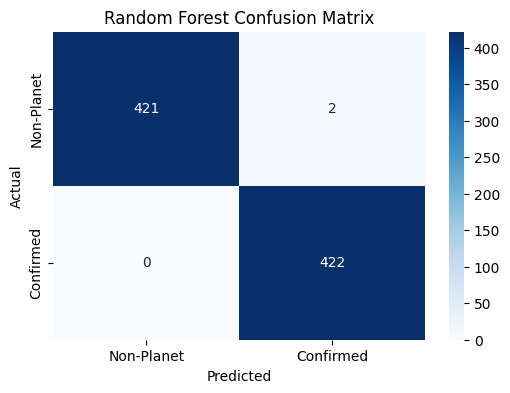

                                        Feature  Importance
2                   Number of planets in system    0.394309
0                                  default_flag    0.093152
51  Host star mass (+ variation) (Solar masses)    0.059099
52  Host star mass (- variation) (Solar masses)    0.035905
65           System distance (+ variation) (pc)    0.031500
66           System distance (- variation) (pc)    0.026283
10           Semi-major axis (+ variation) (AU)    0.020555
11           Semi-major axis (- variation) (AU)    0.019232
19      Planet radius (- variation) (R_Jupiter)    0.018899
64                         System distance (pc)    0.016209


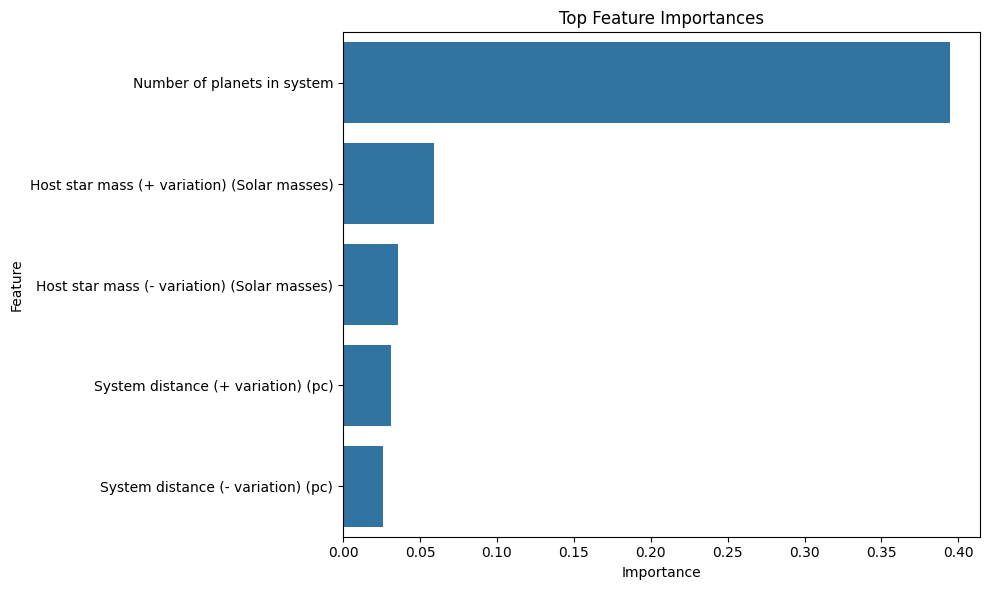

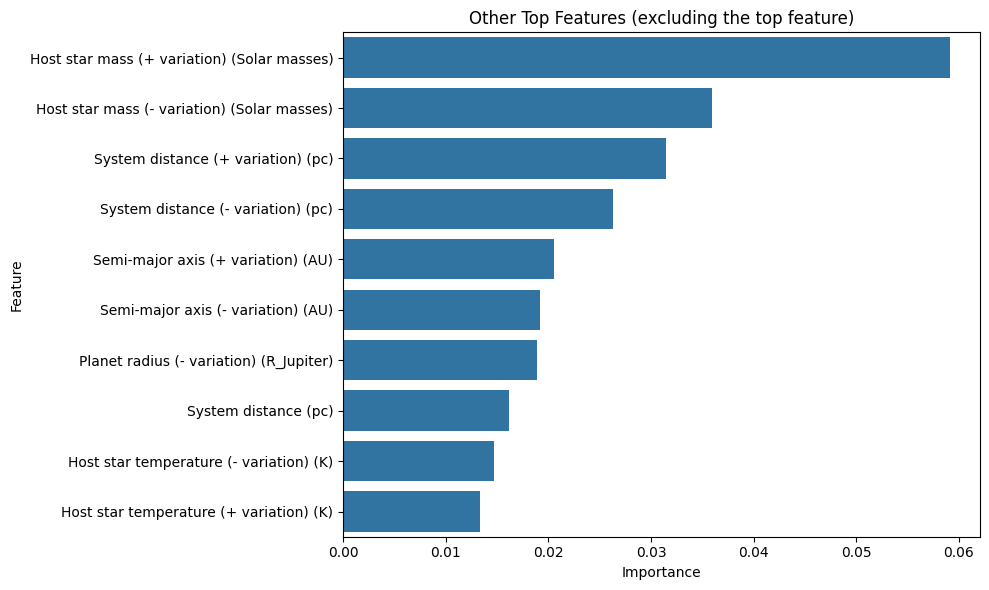

In [88]:
# Random Forest Classifier - Classical machine learning analysis

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import warnings


# Instantiate Random Forest with anti-overfitting tweaks
# Initially the model returned a suspicious 100% accuracy, so added more anti-overfitting parameters
rf = RandomForestClassifier(
    n_estimators=100,       # number of trees
    min_samples_split=10,   # minimum samples to split a node
    max_features='sqrt',    # only consider sqrt(total_features) per split
    random_state=42
)

# Fit the model
rf.fit(X_train_normalized, y_train)

# Predict
y_pred = rf.predict(X_test_normalized)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


#VISUALISATION OF RESULTS -
# Visualise confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Planet','Confirmed'], yticklabels=['Non-Planet','Confirmed'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest Confusion Matrix')
plt.show()


# A dictionary of human-readable names for important columns:
readable_names = {
    'sy_pnum': 'Number of planets in system',
    'st_masserr1': 'Host star mass (+ variation) (Solar masses)',
    'st_masserr2': 'Host star mass (- variation) (Solar masses)',
    'sy_disterr1': 'System distance (+ variation) (pc)',
    'sy_disterr2': 'System distance (- variation) (pc)',
    'pl_orbsmaxerr1': 'Semi-major axis (+ variation) (AU)',
    'pl_orbsmaxerr1': 'Semi-major axis (+ variation) (AU)',
    'pl_orbsmaxerr2': 'Semi-major axis (- variation) (AU)',
     'pl_radjerr2': 'Planet radius (- variation) (R_Jupiter)',
    'sy_dist': 'System distance (pc)',
    'st_tefferr2': 'Host star temperature (- variation) (K)',
    'st_tefferr1': 'Host star temperature (+ variation) (K)',
    'st_mass': 'Host star mass (Solar masses)',
    'pl_orbsmaxlim': 'Semi-major axis limit flag',
    'pl_radj' : 'Planetary radius (in Jupiter radii)',
    'sy_kmag' : 'Star brightness (infrared, K-band)'
}

# Get feature importances
importances = rf.feature_importances_
feature_names = X_train.columns


# Map to human-readable names if available
readable_feature_names = [readable_names.get(f, f) for f in feature_names]

# Take a look at most important features in the categorisation
feat_imp_df = pd.DataFrame({
    'Feature': readable_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)
print(feat_imp_df.head(10))

# Remove redundant features for categorisation
feat_imp_df = feat_imp_df[~feat_imp_df['Feature'].isin(['default_flag', 'disc_year'])]


# Separate the top feature with highest domainance
# (it overshadows the sensitivity of other features)
top_feature = 'Number of planets in system'
top_feat_df = feat_imp_df[feat_imp_df['Feature'] == top_feature]
other_feats_df = feat_imp_df[feat_imp_df['Feature'] != top_feature]


# Plot top 10 most important features,
# this is highlighting the importance of features highly correlated with the presence of confirmed exoplanets
feat_imp_df = feat_imp_df.head(5)



with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)
plt.figure(figsize=(10,6))
sns.barplot(
    x='Importance',
    y='Feature',
    data=feat_imp_df,
   # palette='viridis',
    legend=False # <-- disables extra legend
)

plt.title('Top Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


# Bar chart for other key features
# Plot the remaining features (top 15)
plt.figure(figsize=(10,6))
sns.barplot(
    x='Importance',
    y='Feature',
    data=other_feats_df.head(10),
     legend=False # <-- disables extra legend
)

plt.title('Other Top Features (excluding the top feature)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()





In [ ]:
#Building Neural Network Model
model=Sequential()

# Add input layer
model.add(Dense(units=16,activation='sigmoid', input_shape=(X_train_normalized.shape[1],)))

# Add hidden layers
model.add(Dense(units=8,activation='sigmoid'))
model.add(Dense(units=4,activation='sigmoid'))

# Add the output layer
model.add(Dense(units=1,activation='sigmoid'))  # For binary classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the summary of the model
model.summary()


In [ ]:
# Train the model
model.fit(X_train_normalized, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test_normalized, y_test)

print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

from tensorflow.keras.utils import plot_model

# Plot the model architecture and display it
plot_file = 'model_plot.png'
plot_model(model, to_file=plot_file, show_shapes=True, show_layer_names=True)

# Display the plot inline
display(Image(filename=plot_file))


In [ ]:
# @title
# #first we split then we normalize to prevent data leakage and increase accuracy
# l=['ExoplanetCandidate','ExoplanetConfirmed']
# X=df.drop(l,axis=1)  # Features (excluding the target column)
# y=df['ExoplanetCandidate']  # Target variable
# #Splitting
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=4000/7000, random_state=42,
#                                                     stratify=y # ensures class balance in train/test
# )

# Binary target: 1 = CONFIRMED (CONFIRMED exoplanets only), 0 = non-planets (CANDIDATE, FALSE POSITIVE, REFUTED, etc.)
df['ConfirmedExoplanet'] = df['disposition'].apply(lambda x: 1 if x == 'CONFIRMED' else 0)

# Select numeric columns as features
numeric_cols = df.select_dtypes(include='number').columns
feature_cols = [col for col in numeric_cols if col not in ['ConfirmedExoplanet']]
X = df[feature_cols]
y = df['ConfirmedExoplanet']


# #Splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42,
                                                    stratify=y # ensures class balance in train/test
 )

print("Training set distribution:\n", y_train.value_counts())
print("Testing set distribution:\n", y_test.value_counts())


#Normalizatiom
scaler=StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)


